In [1]:
import pandas as pd
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
import re
import json
from time import strftime

from env import get_db_url

from acquire import get_blog_articles_data, get_news_articles_data, new_spam_data

from prepare import basic_clean, stem, tokenize, lemmatize, remove_stopwords, prep_article_data

## 1. Spam Data

### a. Load the spam data set.

In [2]:
spam_df = new_spam_data()
spam_df.head()

,id,label,text
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [7]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']


In [8]:
def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [9]:
ham_words = clean(' '.join(spam_df[spam_df.label=="ham"]['text']))
spam_words = clean(' '.join(spam_df[spam_df.label=="spam"]['text']))
all_words = clean(' '.join(spam_df['text']))

In [18]:
spam_words

['free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'questionstd',
 'txt',
 'ratetcs',
 'apply',
 '08452810075over18s',
 'freemsg',
 'hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'id',
 'like',
 'fun',
 'still',
 'tb',
 'ok',
 'xxx',
 'std',
 'chgs',
 'send',
 'a150',
 'rcv',
 'winner',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'a900',
 'prize',
 'reward',
 'claim',
 'call',
 '09061701461',
 'claim',
 'code',
 'kl341',
 'valid',
 '12',
 'hour',
 'mobile',
 '11',
 'month',
 'entitled',
 'update',
 'latest',
 'colour',
 'mobile',
 'camera',
 'free',
 'call',
 'mobile',
 'update',
 'co',
 'free',
 '08002986030',
 'six',
 'chance',
 'win',
 'cash',
 '100',
 '20000',
 'pound',
 'txt',
 'csh11',
 'send',
 '87575',
 'cost',
 '150pday',
 '6days',
 '16',
 'tsandcs',
 'apply',
 'reply',
 'hl',
 'info',
 'urgent',
 '1',
 'week',
 'free',
 'membership',
 'a100000',
 'pr

In [10]:


len(all_words), len(spam_words), len(ham_words)



(50018, 12044, 37974)

In [12]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [14]:
word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['ham', 'spam', 'all']

word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [15]:
word_counts.sort_values('all', ascending=False)

,ham,spam,all
call,241,359,600
im,449,13,462
get,314,83,397
ur,240,144,384
go,273,31,304
...,...,...,...
edition,1,0,1
algorithm,1,0,1
textbook,1,0,1
3230,1,0,1


In [16]:
word_counts.sort_values(['ham', 'spam', 'all'], ascending=False)

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
resub,0,1,1
expired,0,1,1
9153,0,1,1
okmail,0,1,1


In [37]:
spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2)).value_counts())
      

spam_bigrams.head()


(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

In [36]:
x = spam_bigrams.str(header=False,
                  index=False,
                  index_names=False).split('\n')
spam_bigram_str = [','.join(ele.split()) for ele in x]
print(spam_bigrams_str)

TypeError: 'StringMethods' object is not callable

In [38]:
ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2)).value_counts())
      

ham_bigrams.head()


(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

In [ ]:
ham_bigrams

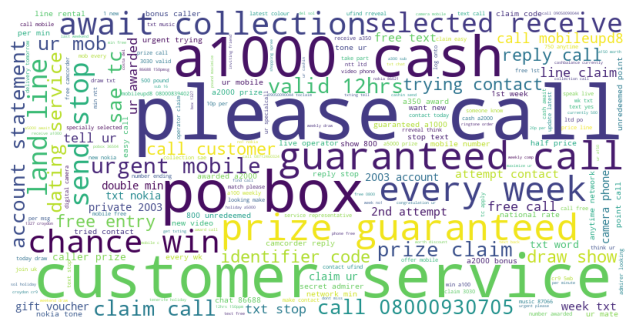

In [39]:
data = {k[0] + ' ' + k[1]: v for k, v in spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


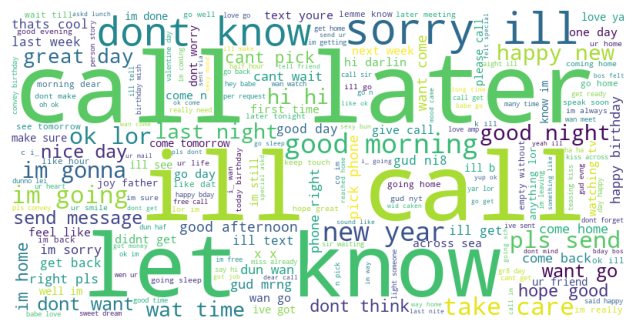

In [40]:
data = {k[0] + ' ' + k[1]: v for k, v in ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


### c. Is there any overlap in the bigrams for the spam data and the ham data?

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [41]:
spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3)).value_counts())
      

spam_trigrams.head()


(prize, guaranteed, call)     21
(call, customer, service)     15
(reply, call, 08000930705)    14
(land, line, claim)           14
(private, 2003, account)      13
dtype: int64

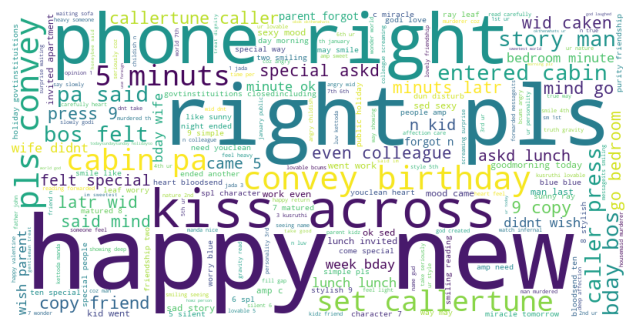

In [43]:
data = {k[0] + ' ' + k[1]: v for k, v in ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


In [42]:
ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3)).value_counts())
      

ham_trigrams.head()


(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(pick, phone, right)    12
dtype: int64

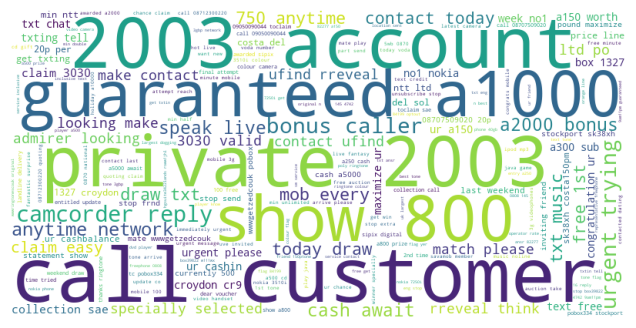

In [44]:
data = {k[0] + ' ' + k[1]: v for k, v in spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [45]:
df_blog = get_blog_articles_data()
df_blog.head()

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...


In [49]:
df_blog = prep_article_data(df_blog, 'content')
df_blog.head()

,title,content,clean,stemmed,lemmatized
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...,may traditionally known asian american pacific...,may tradit known asian american pacif island a...,may traditionally known asian american pacific...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...,women tech panelist spotlight magdalena rahn c...,women tech panelist spotlight magdalena rahn c...,woman tech panelist spotlight magdalena rahn c...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...,women tech panelist spotlight rachel robbinsma...,women tech panelist spotlight rachel robbinsma...,woman tech panelist spotlight rachel robbinsma...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...,women tech panelist spotlight sarah mellor cod...,women tech panelist spotlight sarah mellor cod...,woman tech panelist spotlight sarah mellor cod...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...,women tech panelist spotlight madeleine capper...,women tech panelist spotlight madelein capper ...,woman tech panelist spotlight madeleine capper...


## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.